<a href="https://colab.research.google.com/github/swagata87/IITKanpurPhy654/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Taken from https://www.tensorflow.org/tutorials/keras/regression

In [74]:
# Use seaborn for pairplot.
#pip install -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [75]:
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.15.0


In [77]:
# The Auto MPG dataset
#Mileage per gallon performances of various cars
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [78]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [79]:
#Clean the data, The dataset contains a few unknown values:
dataset.isna().sum()

#Drop those rows
dataset = dataset.dropna()

In [80]:
#The "Origin" column is categorical, not numeric. So the next step is to one-hot encode the values in the column with pd.get_dummies.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [81]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [82]:
# Split the dataset into a training set and a test set.
#You will use the test set in the final evaluation of your models.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [83]:
#Review the dataset
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


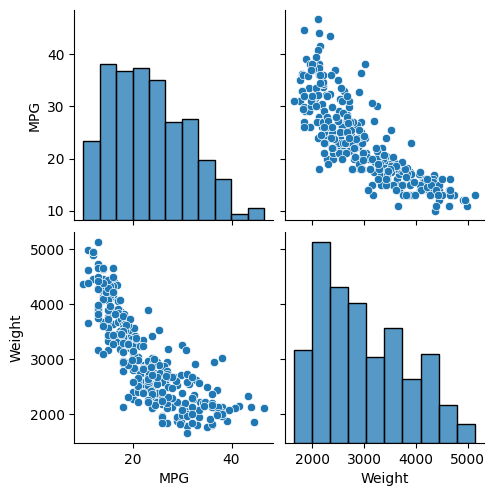

In [84]:
sns.pairplot(train_dataset[['MPG', 'Weight']])


In [85]:
#Separate the target value -- the "label" -- from the features. This label is the value that you will train the model to predict.

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [86]:
train_dataset.describe().transpose()[['mean', 'std']]
#It is good practice to normalize features that use different scales and ranges.

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


In [87]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features).astype(np.float32))
print(normalizer.mean.numpy())


[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [88]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example: ', first)
  print()
  print('Normalized: ', normalizer(first.astype(np.float32) ) )

First example:  [[4 90.0 75.0 2125.0 14.5 74 False False True]]

Normalized:  tf.Tensor([[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]], shape=(1, 9), dtype=float32)


In [89]:
# Try 1: Linear regression
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [90]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [91]:
history = linear_model.fit(
    train_features.astype(np.float32),
    train_labels,
    epochs=100,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 51ms/step - loss: 22.8974 - val_loss: 23.0209
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 22.0590 - val_loss: 22.2948
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 21.2280 - val_loss: 21.5682
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 20.4110 - val_loss: 20.8550
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 19.5814 - val_loss: 20.1062
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 18.7814 - val_loss: 19.3962
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 17.9744 - val_loss: 18.6649
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 17.1624 - val_loss: 17.9338
Epoch 9/100
8/8 [==============================] - 0s 22ms/step - loss: 16.3464 - val_loss: 17.2218
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 15.5401 - val_loss: 16.4772

In [92]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.482488,2.487502,95
96,2.491784,2.458283,96
97,2.489995,2.494536,97
98,2.482778,2.480035,98
99,2.484179,2.481488,99


In [93]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

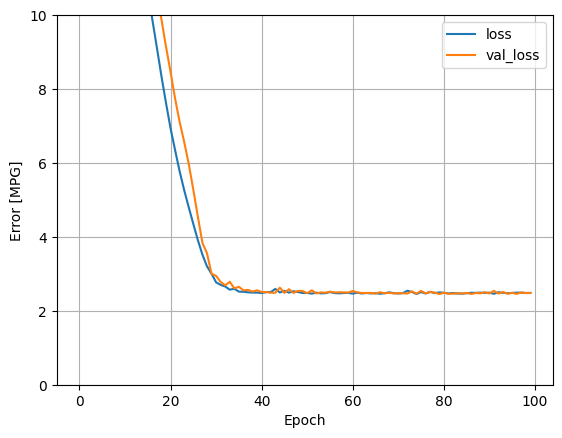

In [94]:
plot_loss(history)


In [95]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features.astype(np.float32), test_labels)

3/3 [==============================] - 0s 6ms/step - loss: 2.4785


In [96]:
# Regression with a deep neural network (DNN)
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [97]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [98]:
history = dnn_model.fit(
    train_features.astype(np.float32),
    train_labels,
    validation_split=0.2,
    epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 32ms/step - loss: 22.5950 - val_loss: 22.5632
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 21.8274 - val_loss: 21.6543
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 20.9261 - val_loss: 20.5467
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 19.8065 - val_loss: 19.1227
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 18.3516 - val_loss: 17.2644
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 16.4589 - val_loss: 15.0687
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 14.3633 - val_loss: 12.9526
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 12.1103 - val_loss: 10.7078
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 9.6947 - val_loss: 8.2998
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 7.3058 - val_loss: 6.2726
Epoch 11/100

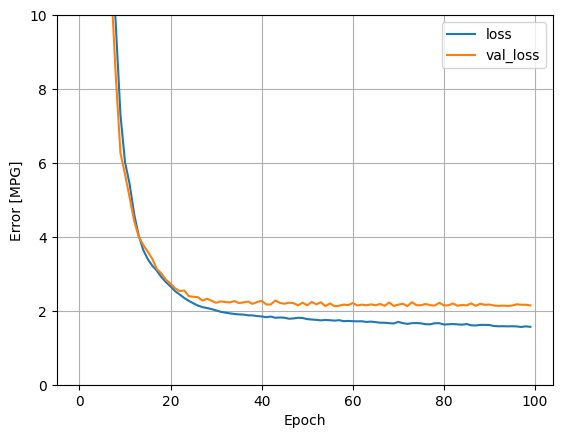

In [99]:
plot_loss(history)


In [100]:
test_results['dnn_model'] = dnn_model.evaluate(test_features.astype(np.float32), test_labels, verbose=0)


In [101]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T


,Mean absolute error [MPG]
linear_model,2.478488
dnn_model,1.676840


3/3 [==============================] - 0s 5ms/step


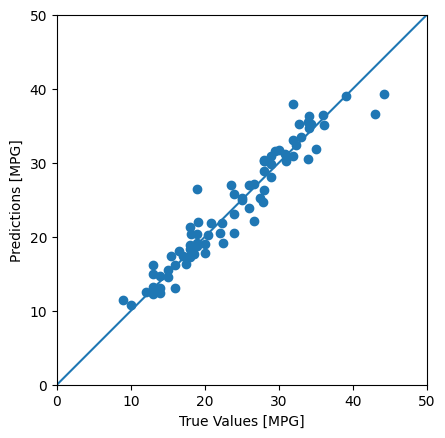

In [110]:
test_predictions = dnn_model.predict(test_features.astype(np.float32)).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

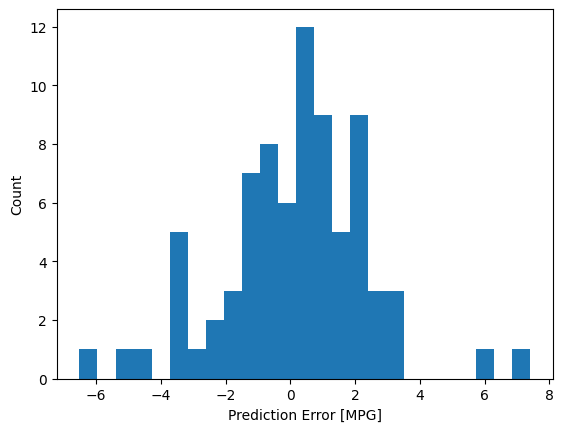

In [111]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')

In [106]:
dnn_model.save('dnn_model.keras')